In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder  
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(r'D:\ds_ridwan\fertilizer-optimizer\data\raw\train.csv')
df.drop(columns=['id'], inplace=True)
df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 51.5+ MB


In [12]:
print(f'Fitur di Soil Type: {df["Soil Type"].unique()}\n')
print(f'Fitur di Crop Type: {df["Crop Type"].unique()}\n')
print(f'Fitur di Target: {df["Fertilizer Name"].unique()}')

Fitur di Soil Type: ['Clayey' 'Sandy' 'Red' 'Loamy' 'Black']

Fitur di Crop Type: ['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']

Fitur di Target: ['28-28' '17-17-17' '10-26-26' 'DAP' '20-20' '14-35-14' 'Urea']


In [ ]:
# gaterlalu penting sih tapi ya anw wkwk
cat_cols  = [col for col in df.columns if df[col].dtype == 'O']
num_cols  = [col for col in df.columns if df[col].dtype != 'O']

['Soil Type', 'Crop Type', 'Fertilizer Name']

In [ ]:
def univariate_numerical_analysis(df,cols):
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

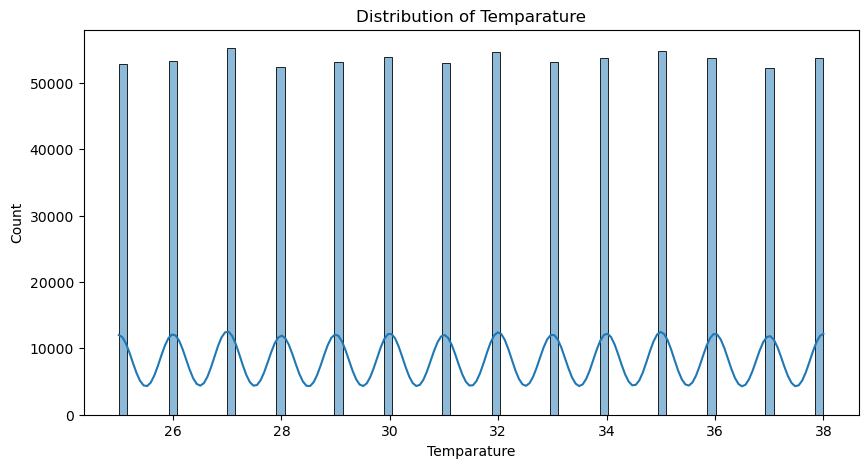

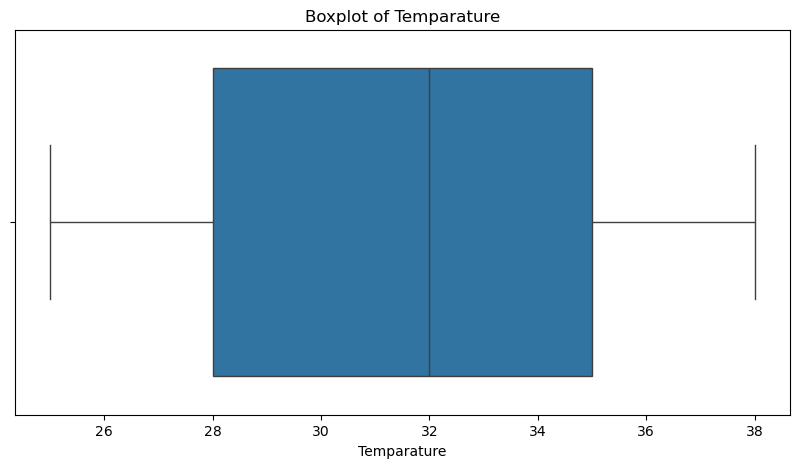

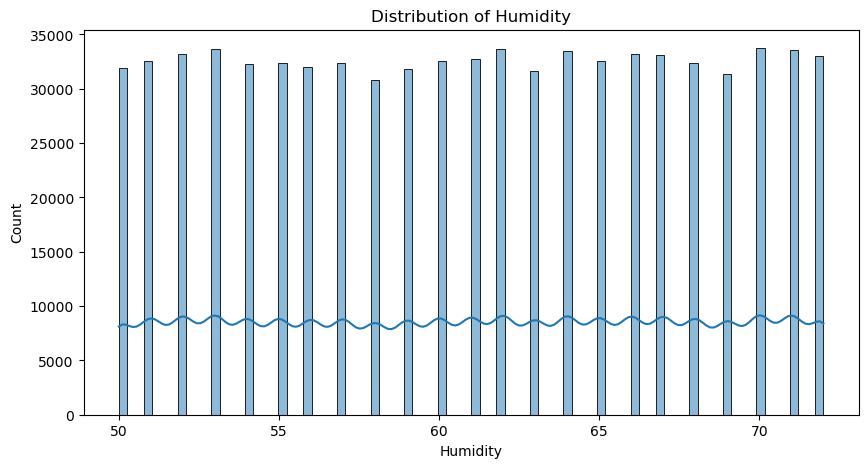

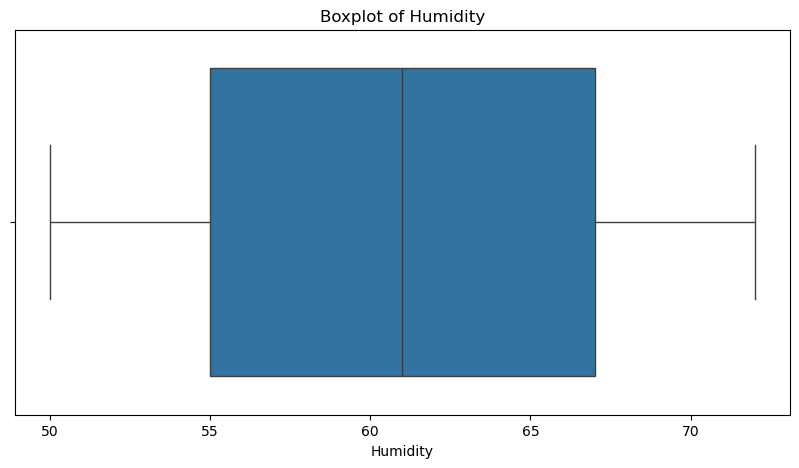

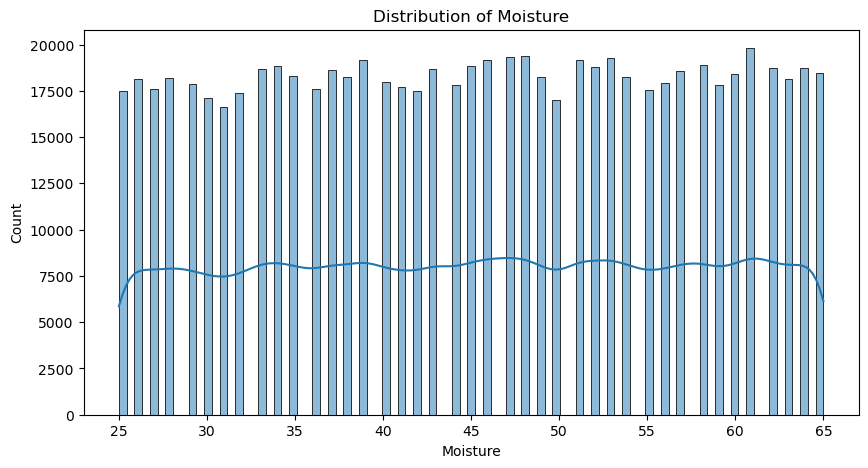

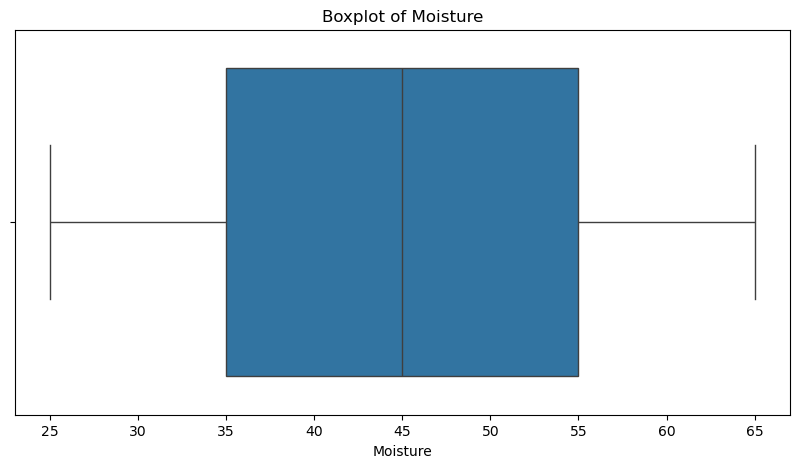

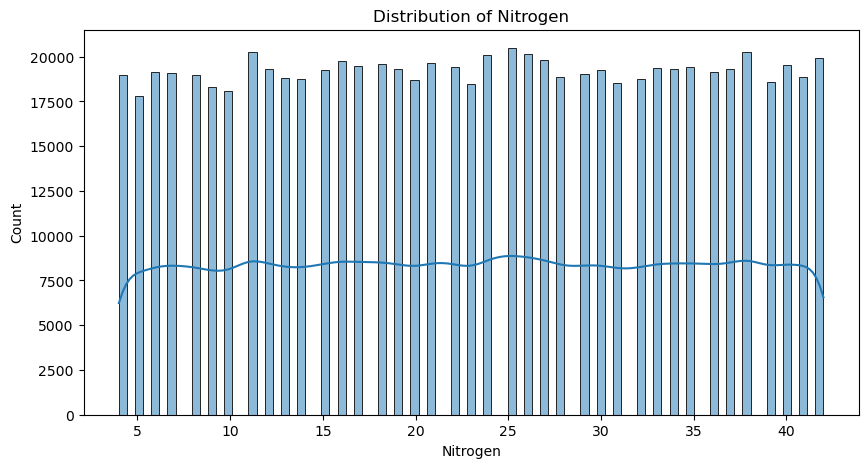

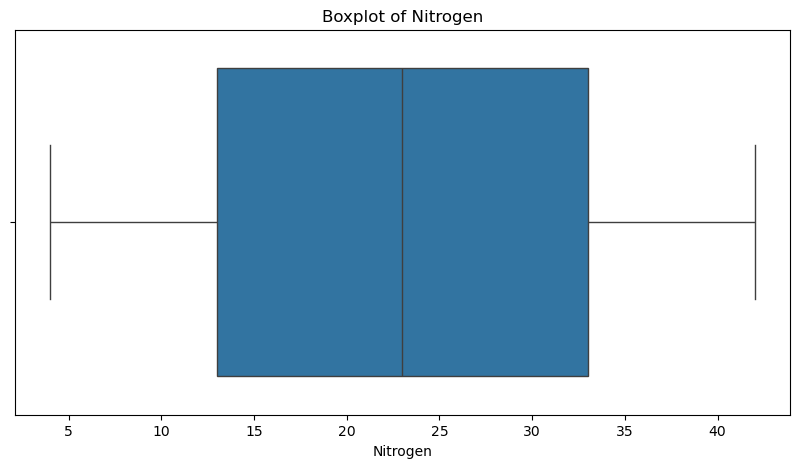

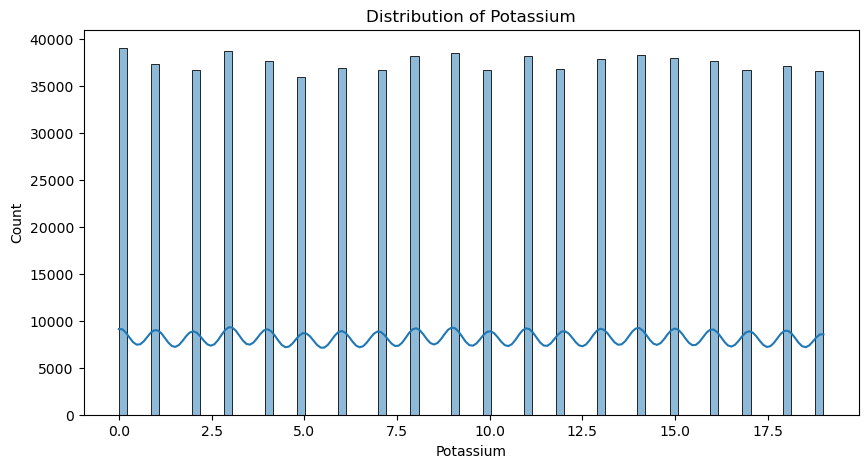

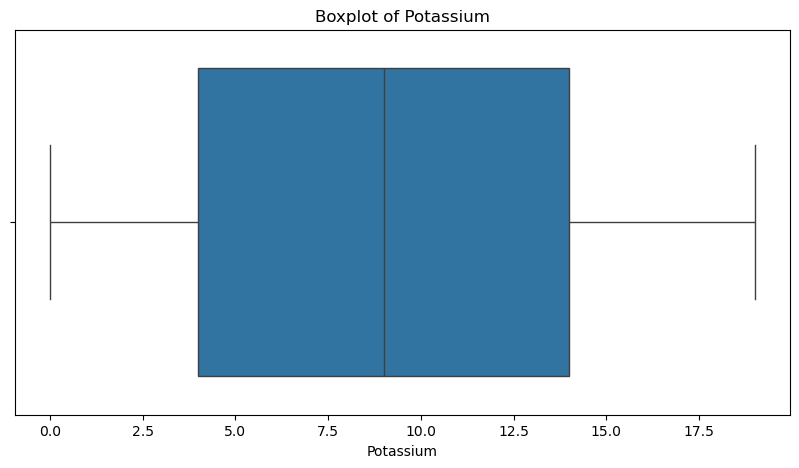

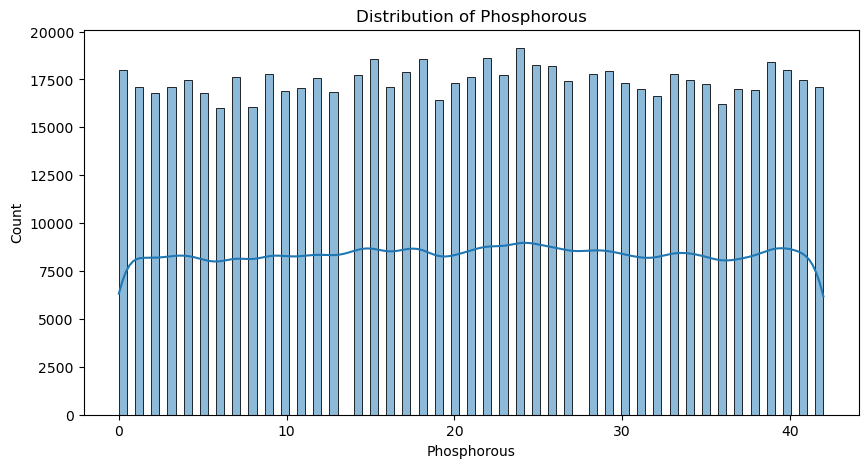

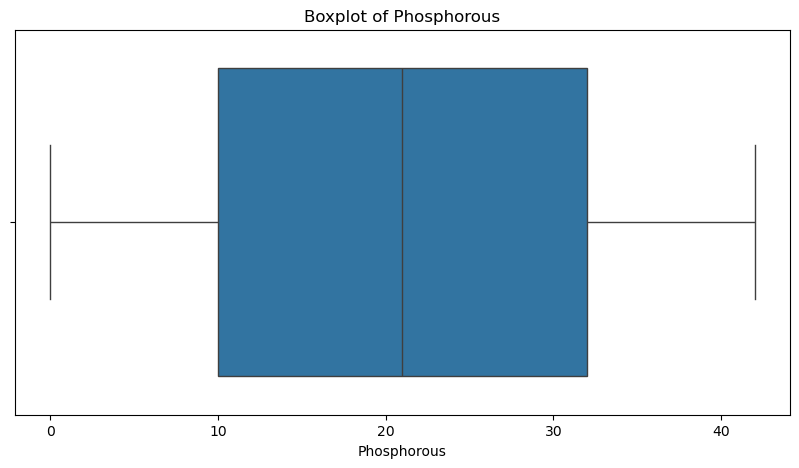

In [23]:
univariate_numerical_analysis(df, num_cols)

##### | Rupanya semua kategori LOL, pentingnya melihat masing masing berapa uniquenya wkwkwk 😆😆😆

In [27]:
print(df.nunique())

Temparature        14
Humidity           23
Moisture           41
Soil Type           5
Crop Type          11
Nitrogen           39
Potassium          20
Phosphorous        43
Fertilizer Name     7
dtype: int64


In [28]:
def plot_categorical_distributions(df, cols, target='Fertilizer Name', max_uniques=20):
    """
    Visualize distribution of categorical features
    """
    print("="*80)
    print("CATEGORICAL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    plt.figure(figsize=(20, 25))
    for i, col in enumerate(cols, 1):
        # Skip target column
        if col == target:
            continue
            
        plt.subplot(4, 3, i)
        
        # For features with many categories, show top N
        if df[col].nunique() > max_uniques:
            top_categories = df[col].value_counts().nlargest(max_uniques).index
            temp_df = df[df[col].isin(top_categories)]
            sns.countplot(data=temp_df, x=col, order=top_categories)
        else:
            sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        
        plt.title(f'Distribution of {col} (nunique={df[col].nunique()})')
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()

def plot_heatmap_relationships(df, cols, target='Fertilizer Name'):
    """
    Plot heatmaps showing relationships between categorical features
    """
    print("="*80)
    print("CATEGORICAL RELATIONSHIP ANALYSIS")
    print("="*80)
    
    # Heatmap for each feature vs target
    for col in cols:
        if col == target:
            continue
            
        plt.figure(figsize=(12, 8))
        crosstab = pd.crosstab(df[col], df[target], normalize='index')
        sns.heatmap(crosstab, annot=True, fmt='.2f', cmap='Blues')
        plt.title(f'Relationship between {col} and {target}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    # Pairwise heatmap between features (for features with fewer categories)
    small_cardinality_cols = [col for col in cols if df[col].nunique() < 10 and col != target]
    
    if len(small_cardinality_cols) > 1:
        for i in range(len(small_cardinality_cols)):
            for j in range(i+1, len(small_cardinality_cols)):
                col1, col2 = small_cardinality_cols[i], small_cardinality_cols[j]
                plt.figure(figsize=(12, 8))
                crosstab = pd.crosstab(df[col1], df[col2], normalize='index')
                sns.heatmap(crosstab, annot=True, fmt='.2f', cmap='Blues')
                plt.title(f'Relationship between {col1} and {col2}')
                plt.show()

def plot_stacked_distributions(df, cols, target='Fertilizer Name', max_uniques=10):
    """
    Plot stacked bar charts showing how categories distribute across target
    """
    print("="*80)
    print("STACKED DISTRIBUTION BY TARGET")
    print("="*80)
    
    for col in cols:
        if col == target or df[col].nunique() > max_uniques:
            continue
            
        plt.figure(figsize=(12, 6))
        cross_tab = pd.crosstab(df[col], df[target], normalize='index') * 100
        cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title(f'Distribution of {target} across {col} categories')
        plt.ylabel('Percentage (%)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def categorical_statistical_tests(df, cols, target='Fertilizer Name'):
    """
    Perform statistical tests for categorical-categorical relationships
    """
    print("="*80)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*80)
    
    for col in cols:
        if col == target:
            continue
            
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"\n{col} vs {target}:")
        print(f"Chi-squared statistic: {chi2:.2f}")
        print(f"P-value: {p:.4f}")
        print(f"Degrees of freedom: {dof}")
        
        # Calculate Cramer's V (effect size measure)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))
        print(f"Cramer's V: {cramers_v:.3f}")
        
        # Interpretation
        print("\nEffect size interpretation:")
        if cramers_v < 0.1:
            print("Very weak association")
        elif cramers_v < 0.2:
            print("Weak association")
        elif cramers_v < 0.4:
            print("Moderate association")
        elif cramers_v < 0.6:
            print("Relatively strong association")
        else:
            print("Strong association")

def full_categorical_eda(df, cols, target='Fertilizer Name'):
    """
    Run complete EDA for categorical dataset
    """
    # Basic info
    print("Dataset Shape:", df.shape)
    print("\nTarget Distribution:")
    print(df[target].value_counts(normalize=True))
    
    # Visual analysis
    plot_categorical_distributions(df, cols, target)
    plot_stacked_distributions(df, cols, target)
    plot_heatmap_relationships(df, cols, target)
    
    # Statistical analysis
    categorical_statistical_tests(df, cols, target)

Dataset Shape: (750000, 9)

Target Distribution:
Fertilizer Name
14-35-14    0.152581
10-26-26    0.151849
17-17-17    0.149937
28-28       0.148211
20-20       0.147852
DAP         0.126480
Urea        0.123089
Name: proportion, dtype: float64
CATEGORICAL DISTRIBUTION ANALYSIS


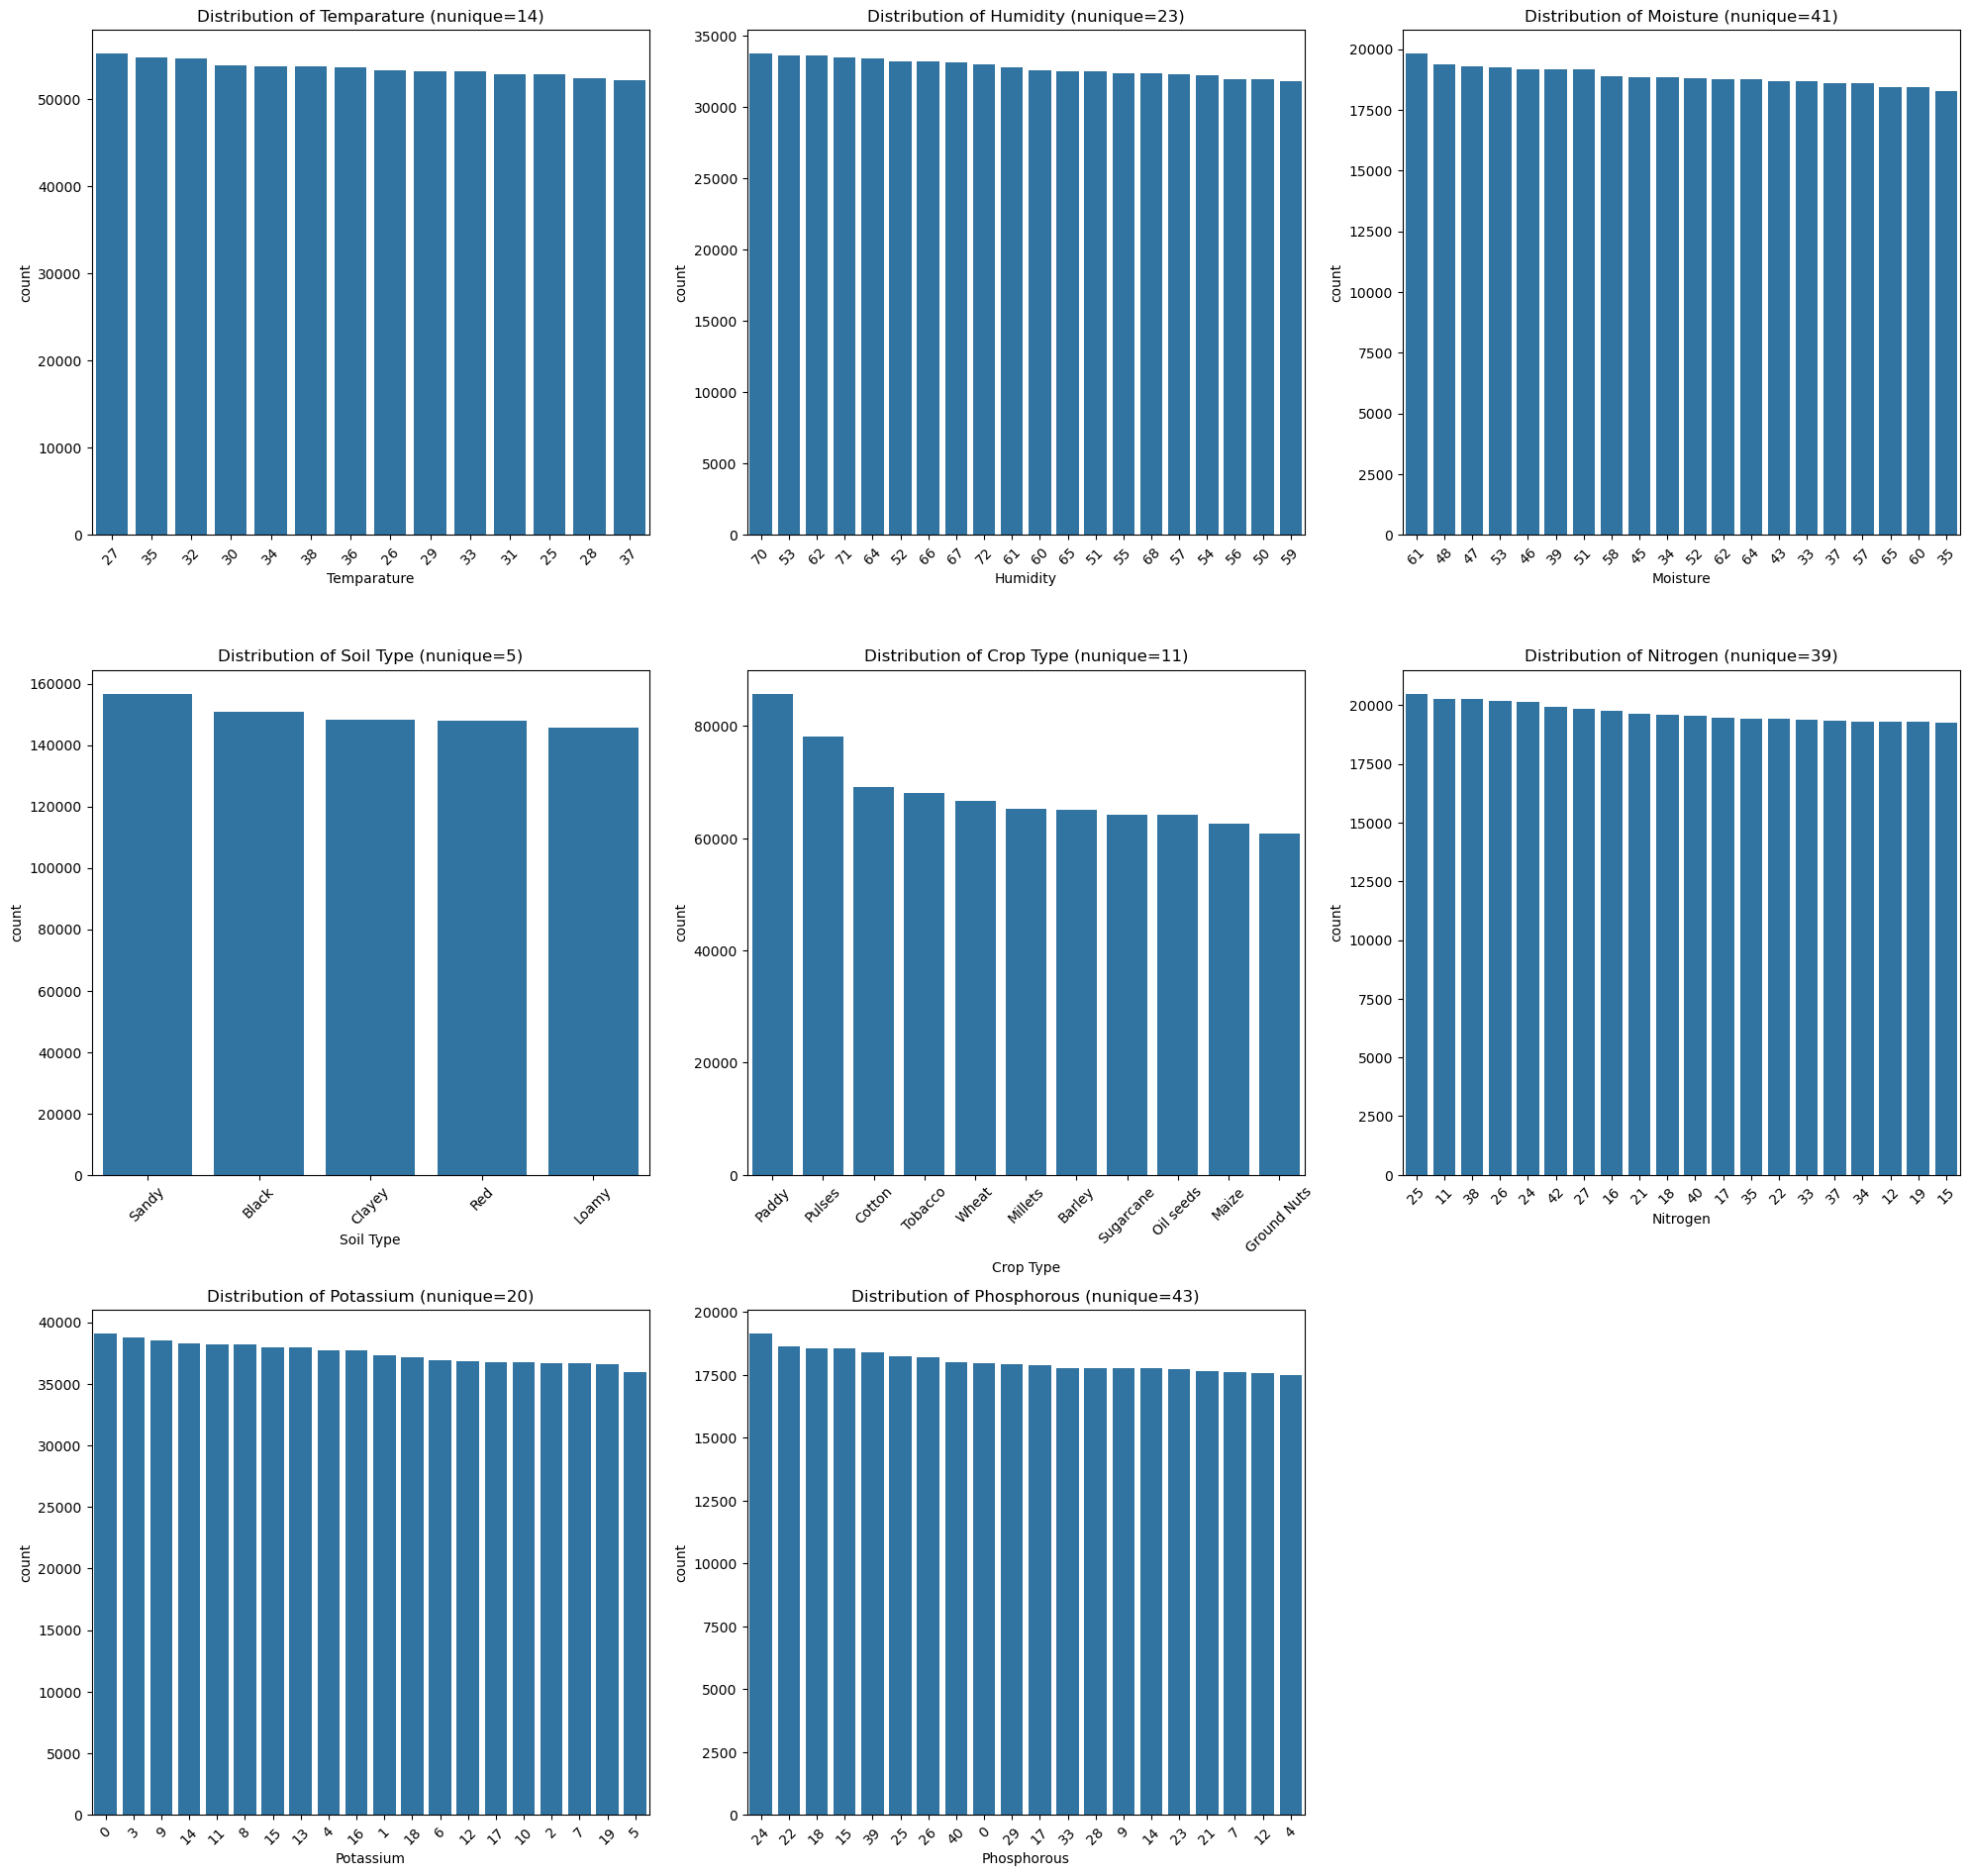

STACKED DISTRIBUTION BY TARGET


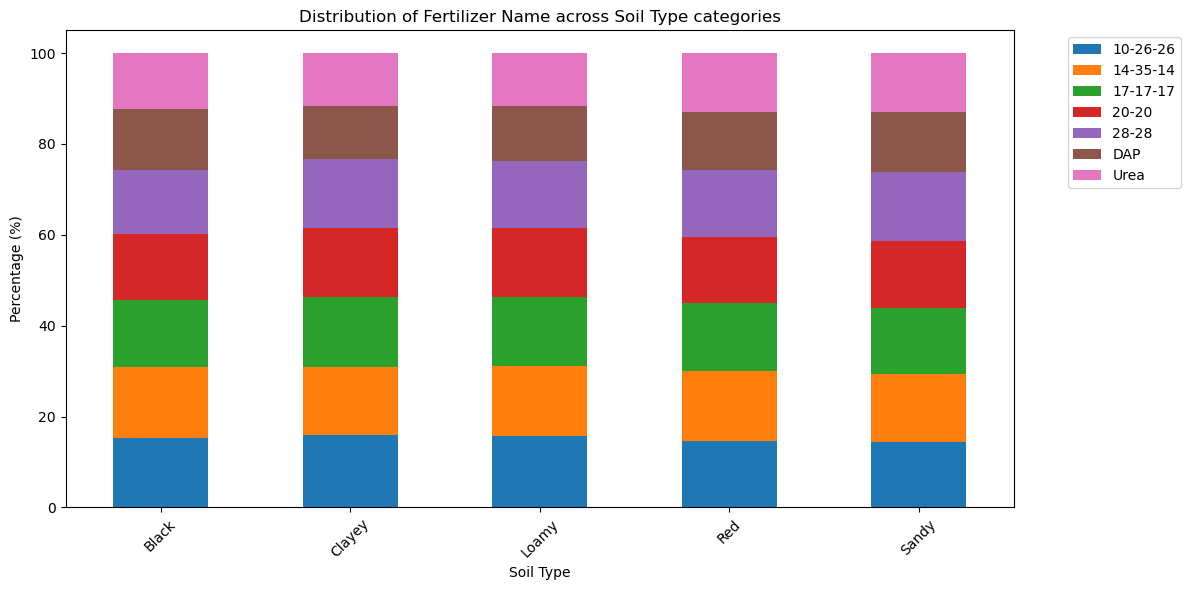

CATEGORICAL RELATIONSHIP ANALYSIS


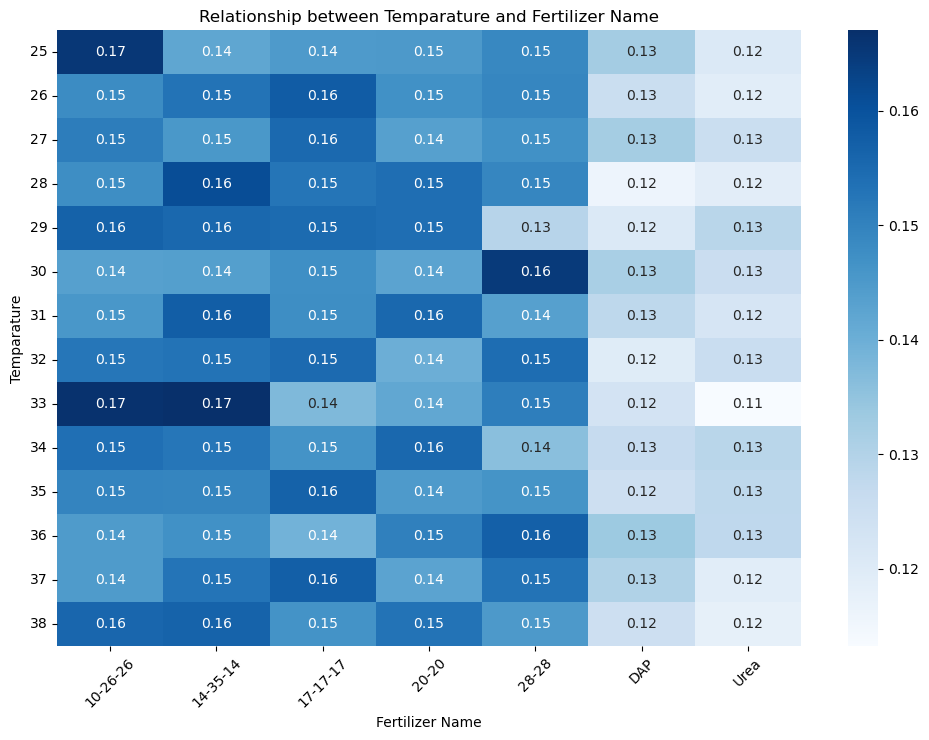

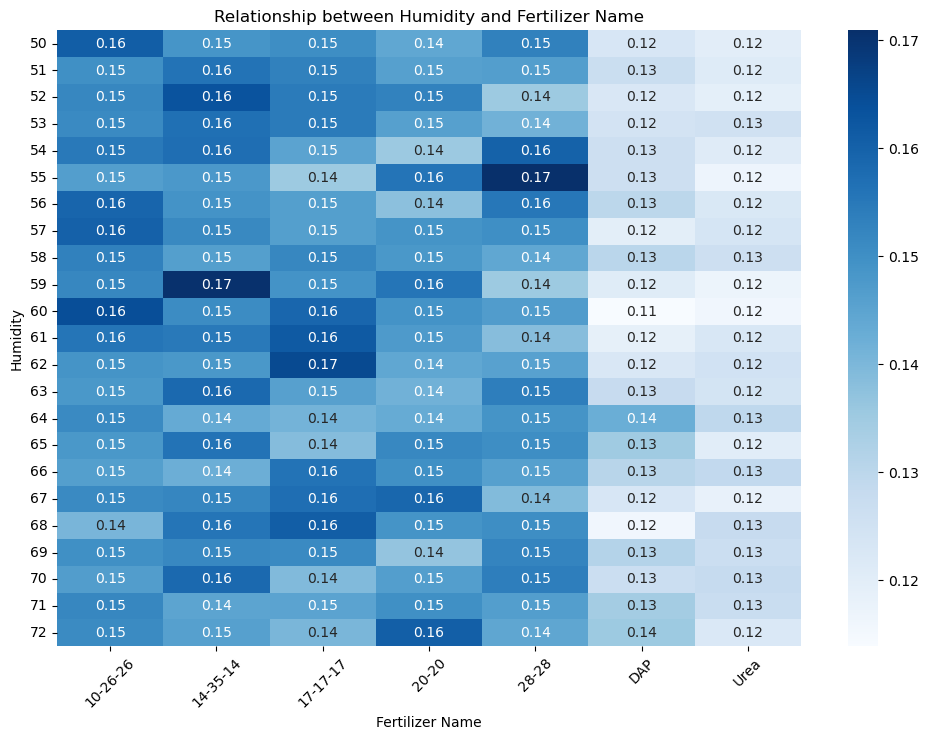

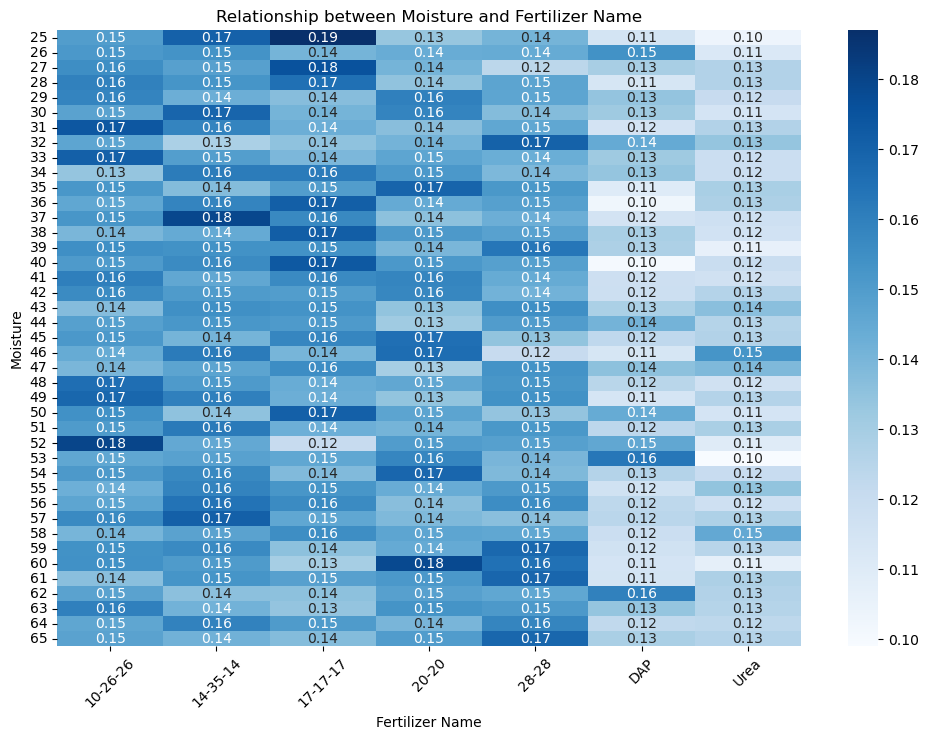

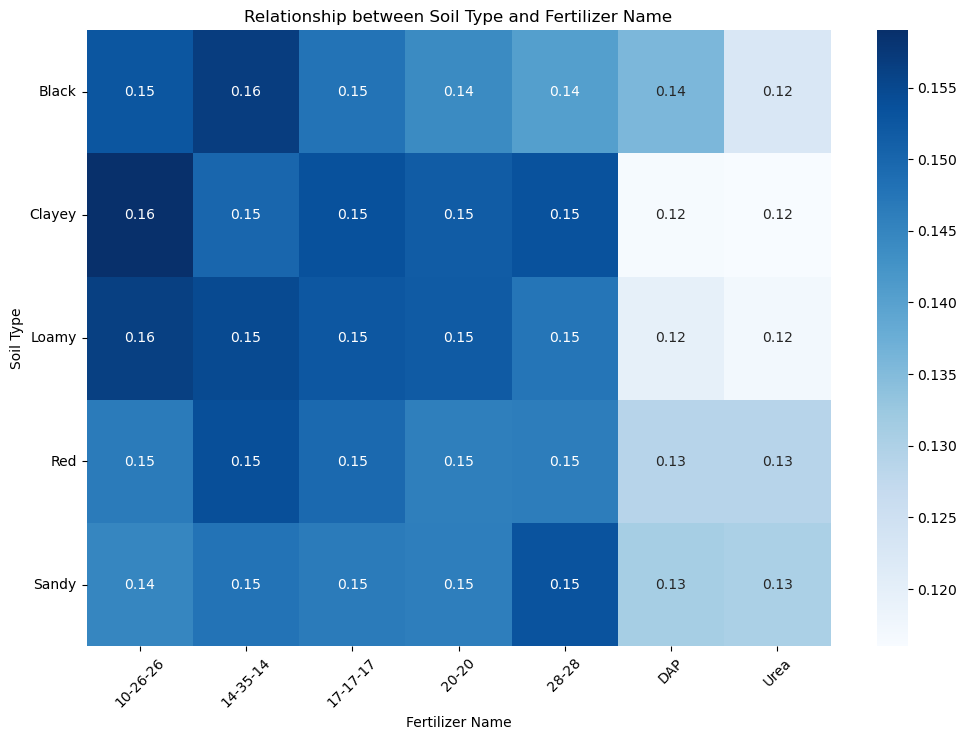

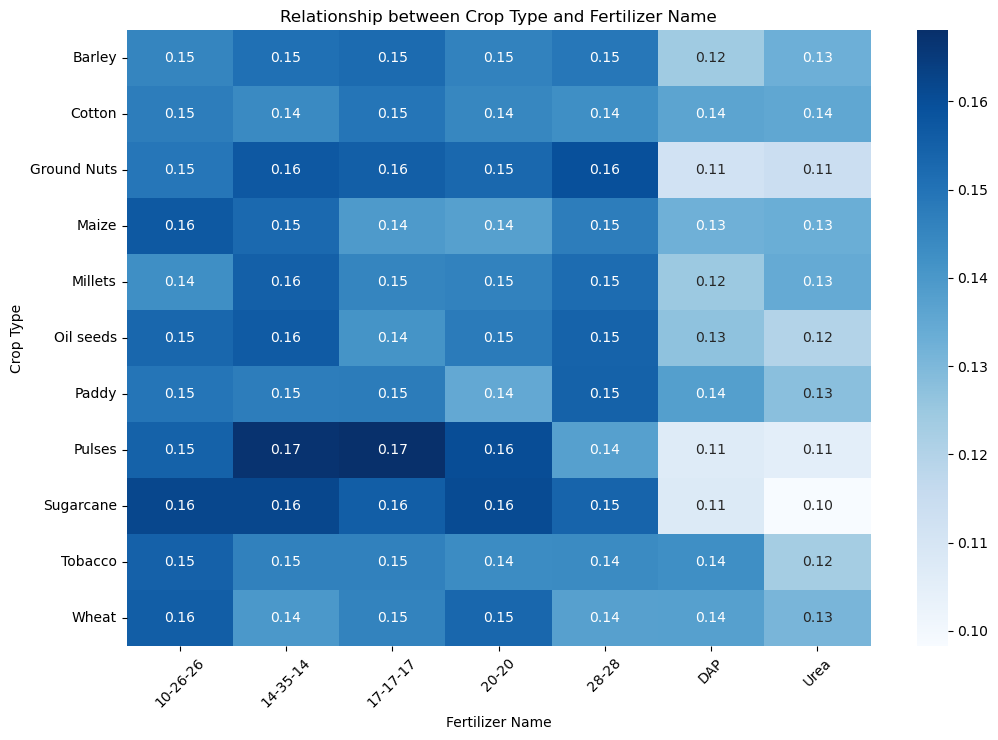

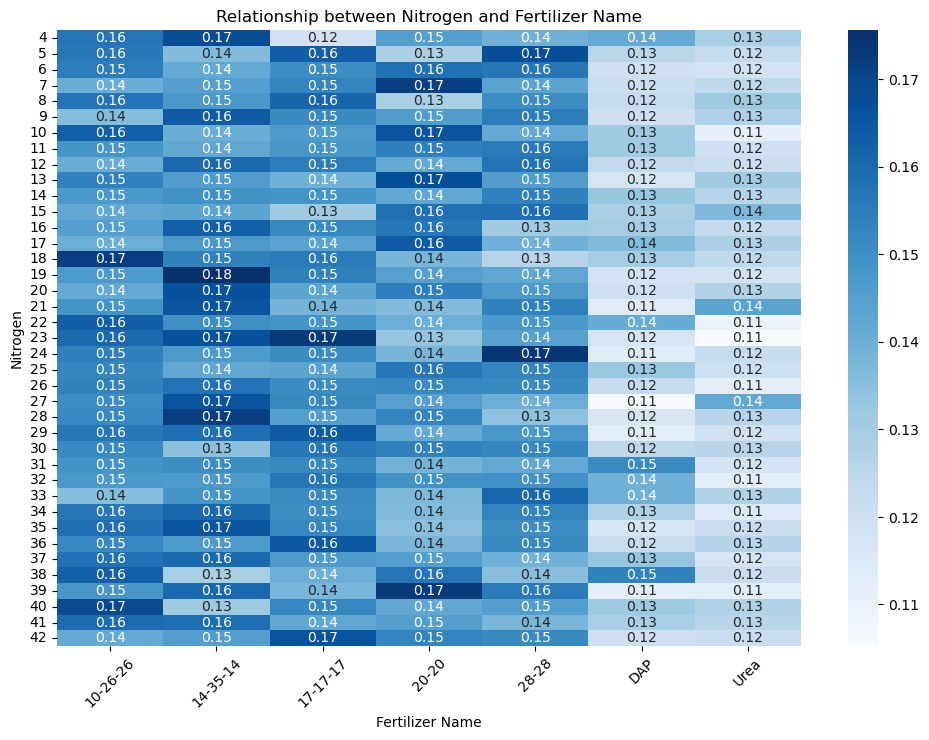

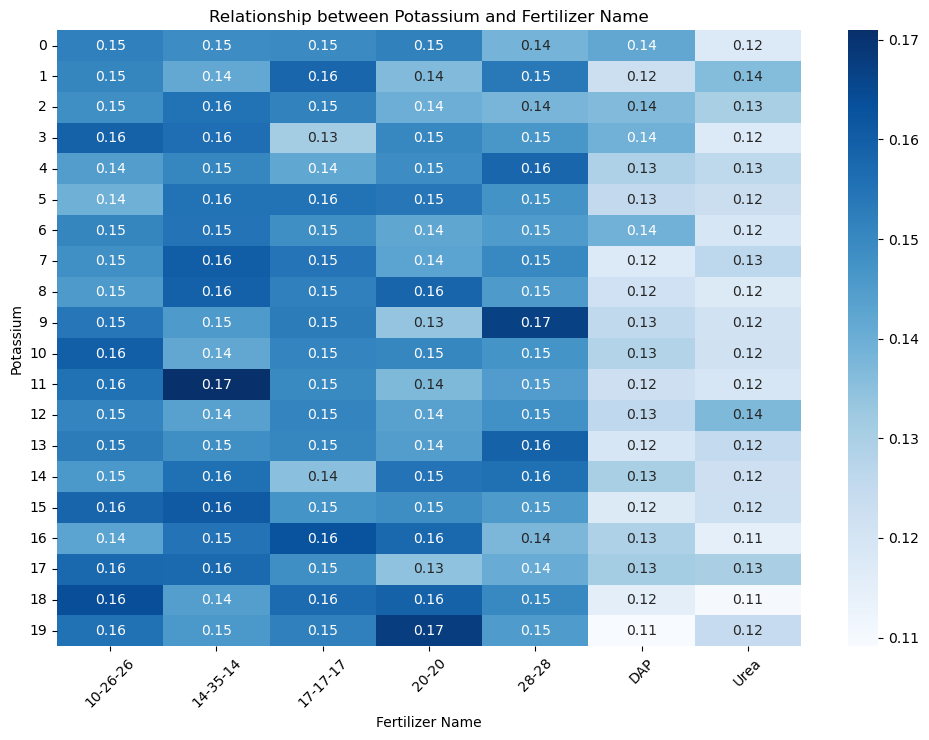

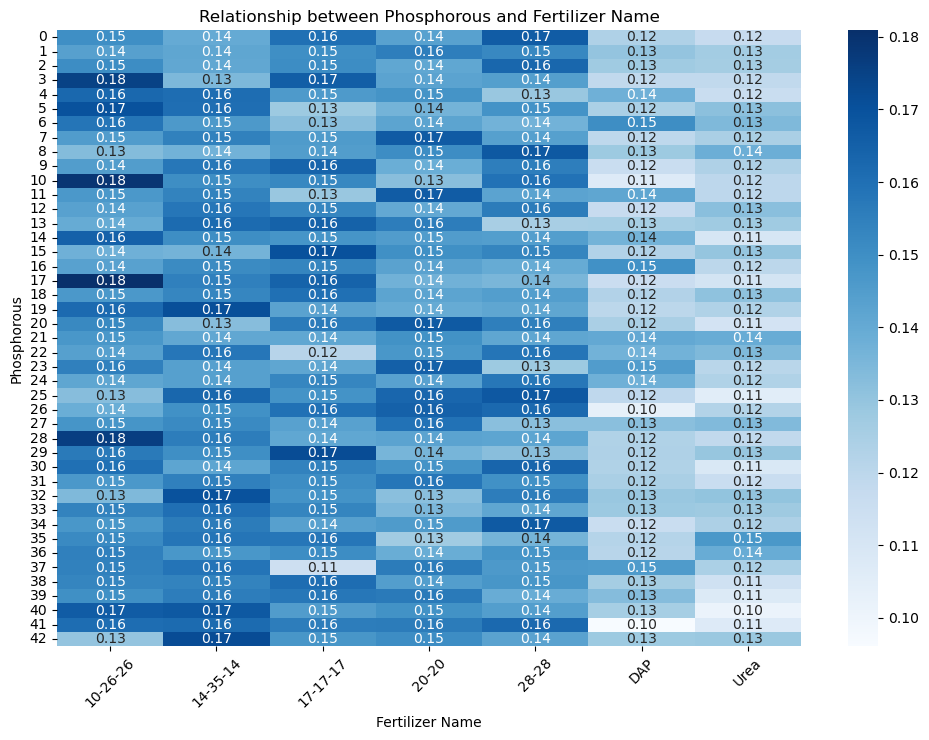

STATISTICAL SIGNIFICANCE TESTS

Temparature vs Fertilizer Name:
Chi-squared statistic: 1447.28
P-value: 0.0000
Degrees of freedom: 78
Cramer's V: 0.018

Effect size interpretation:
Very weak association

Humidity vs Fertilizer Name:
Chi-squared statistic: 1529.01
P-value: 0.0000
Degrees of freedom: 132
Cramer's V: 0.018

Effect size interpretation:
Very weak association

Moisture vs Fertilizer Name:
Chi-squared statistic: 5012.81
P-value: 0.0000
Degrees of freedom: 240
Cramer's V: 0.033

Effect size interpretation:
Very weak association

Soil Type vs Fertilizer Name:
Chi-squared statistic: 923.33
P-value: 0.0000
Degrees of freedom: 24
Cramer's V: 0.018

Effect size interpretation:
Very weak association

Crop Type vs Fertilizer Name:
Chi-squared statistic: 3094.46
P-value: 0.0000
Degrees of freedom: 60
Cramer's V: 0.026

Effect size interpretation:
Very weak association

Nitrogen vs Fertilizer Name:
Chi-squared statistic: 3567.74
P-value: 0.0000
Degrees of freedom: 228
Cramer's V: 0.028

In [29]:
full_categorical_eda(df, df.columns, 'Fertilizer Name')

## Ready to the <b>GAME 🎮

In [41]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Enhanced custom encoder yang beneran bisa dipake di Pipeline"""
    def __init__(self, threshold=10, handle_unknown='ignore'):
        self.threshold = threshold
        self.handle_unknown = handle_unknown
        self.encoders = {}
        self.high_card_cols = []
        self.low_card_cols = []
        
    def fit(self, X, y=None):
        for col in X.columns:
            if X[col].nunique() > self.threshold:
                self.high_card_cols.append(col)
                # Pakai TargetEncoder untuk high cardinality
                encoder = TargetEncoder(handle_unknown='value', handle_missing='value')
                encoder.fit(X[col], y)
                self.encoders[col] = encoder
            else:
                self.low_card_cols.append(col)
                # Pakai OneHotEncoder untuk low cardinality
                encoder = OneHotEncoder(handle_unknown=self.handle_unknown, sparse=False)
                encoder.fit(X[[col]])
                self.encoders[col] = encoder
        return self
    
    def transform(self, X, y=None):
        X_transformed = pd.DataFrame()
        
        for col in X.columns:
            if col in self.high_card_cols:
                # Transform pake TargetEncoder
                encoded = self.encoders[col].transform(X[col])
                X_transformed[col] = encoded
            else:
                # Transform pake OneHotEncoder
                encoded = self.encoders[col].transform(X[[col]])
                cols = [f"{col}_{cat}" for cat in self.encoders[col].categories_[0]]
                encoded_df = pd.DataFrame(encoded, columns=cols, index=X.index)
                X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
                
        return X_transformed
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [42]:
# data preparation
def prepare_data(df,target_col='Fertilizer Name'):
    # Pisahkan fitur dan target
    le = LabelEncoder()
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return X, y, le

In [43]:
# modeling
def evaluate_model(model,X,y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    acc_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')

    print(f"Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    return acc_scores, f1_scores

In [44]:
def run_baseline_models(X,y):
    #preprocessing
    preprocessor = CategoricalEncoder(threshold=10)
    X_processed = preprocessor.fit_transform(X, y)

    #models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(),
        'ElasticNet': ElasticNet()
    }

    results = {}
    for name, model in models.items():
        print(f"Eval {name}...")
        acc, f1 = evaluate_model(model, X_processed, y)
        results[name] = {'Accuracy': acc, 'F1 Score': f1}
    return results
        

In [45]:
# Main Workflow
def main_workflow(df):
    # Prepare data
    X, y, label_encoder = prepare_data(df)
    
    # Run baseline models
    results = run_baseline_models(X, y)
    
    return results, label_encoder

In [48]:
results, le = main_workflow(df)

AttributeError: 'super' object has no attribute '__sklearn_tags__'